# Brazilian E-Commerce Dataset by Olist

# NLP - Topic Modelling

In the following section we will look into applying topic modelling to the reviews. Topic modelling is an unsupervised algorithm used for recognition word and phrase patterns and by using that categorizing each review. As a business case for OLIST topic modelling is very interesting as a good model lets them categorize their reviews automatically, thus reducing the amount of manual work going through reviews manually. Goodwill and a proper relationship with customers is essential to sellers. Therefor, sellers often seek to respond to reviews, whether they are good or bad, to show they are committed to their customers. But for a company of the size of OLIST, depending on the topic different people should respond. This could be delivery-service, people responsible for product quality, packaging etc. <br>
The data for OLIST is in portugese, which means we are going to use a Portugese Stemmer and for final interpretation of models use Google's Translation API.

#### KPI - Key Performance Indicator

*Reducing the number of manual taskes and automating the assigning of reviews to different proccesses an order.* <br>
This KPI should reduce labour costs of employees going through and distributing reviews. For those not usually responding to reviews, this automatic distribution of relevant reviews will encourage them to respond, thus achieving a healthier relationship with the customers.

**Packages for Section**

In [304]:
import numpy as np
import pandas as pd
import sys, os
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

#Data cleaning
import string
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')
nltk.download('rslp')
portugese_stopwords = nltk.corpus.stopwords.words('portuguese')
##Extend stopwords list to ensure extensive version (Link collapsed)
stop = pd.read_csv('https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt',header=None)
portugese_stopwords.extend(stop.values.ravel())

#Gensim:
from gensim import models
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

#SciKitLearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV



#Visuals:
import wordcloud
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium.plugins import HeatMap
from IPython.display import Image
from IPython.core.display import HTML 



#Google Translation API
from googletrans import Translator
translator = Translator()

#Set seed
import random
random.seed(42)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


### Load dataset

The available datasets for Brazilian E-Commerce Public Dataset will be merged into the final dataset. <br>
    - olist_order_items_dataset
    - olist_order_payments_dataset
    - olist_orders_dataset
    - olist_order_reviews_dataset
    - olist_products_dataset
    - olist_customers_dataset
    - product_category_name_translation

In [10]:
orders = pd.read_csv('data/olist_orders_dataset.csv')
payments = pd.read_csv('data/olist_order_payments_dataset.csv')
items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
category = pd.read_csv('data/product_category_name_translation.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

The files are merged by a left-join operation acording to the following data schema.



In [11]:
Image(url='https://i.imgur.com/HRhd2Y0.png',width=600)

In [307]:
#Merge of the data files into a final united dataset
df = customer.merge(orders, on='customer_id', how='left')
df = df.merge(payments, on='order_id', how='left')
df = df.merge(items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(category, on='product_category_name', how='left')
df = df.merge(reviews, on='order_id', how='left')

#### Reduction of dataset

The Brazilian E-Commerce Public Dataset is quite large, therefore it may require more computational resources than our computers have available. The report is therefor only using a subset of the data. The two other reports reduced their data to only containing customers within the area of Sao Paulo, but that did not include enough reviews, thus the Topic Modelling will be based on 50% of the data.<br>
Sao Paolo was initially chosen as it, as shown below, has the highest density in customers.

In [308]:
print('Shape before reduction:')
print(df.shape)

#Reduce to half the size
df_red = df.sample(frac=0.5,random_state=42)
print('Shape after reduction:')
print(df_red.shape)

#The final dataset for the recommender system part
df_red.head()
#Converting creation date to proper format
df_red.review_creation_date = pd.to_datetime(df_red.review_creation_date)

Shape before reduction:
(119151, 37)
Shape after reduction:
(59576, 37)


In [52]:
geo = pd.read_csv('data/olist_geolocation_dataset.csv')
customer = pd.read_csv('data/olist_customers_dataset.csv')

agg_geo = geo.groupby('geolocation_zip_code_prefix').mean()
geo_cust_count = pd.merge(customer.set_index('customer_zip_code_prefix'),agg_geo,how='left', left_index=True, right_index=True)

mapp = folium.Map(location=[-15.8267,-47.9218],
                  zoom_start = 4.5, tiles='Stamen Toner')

heat_df = geo_cust_count[['geolocation_lat', 'geolocation_lng']]
heat_df = heat_df.dropna(axis=0, subset=['geolocation_lat', 'geolocation_lng'])

# List comprehension to make out list of lists
heat_data = [[row['geolocation_lat'],row['geolocation_lng']] for index, row in heat_df.iterrows()]

HeatMap(heat_data,min_opacity=0.5,blur=30).add_to(mapp)
mapp



### Choosing only the relevant features
We are choosing the two columns needed from our data, which are the review comment and the review score to see if the different topics have certain trends when it comes to average review score.

In [116]:
NLP_data = df_red[['review_comment_message','review_score']]
NLP_data.head()

review_comment_message  review_score
82974   Fui retirar o produto no correio, pois não ent...             4
83690                                                 NaN             5
12758                                                 NaN             5
118288  Comprei e paguei por um produto que nao veio,a...             1
64653                                                 NaN             4

It appears that the review comment has missing data, which is removed.

In [117]:
print('Number of reviews with no text:', len(NLP_data.review_comment_message)-NLP_data.review_comment_message.count())
print('In percentage:', (len(NLP_data.review_comment_message)-NLP_data.review_comment_message.count())/len(NLP_data.review_comment_message),'%')

Number of reviews with no text: 34006
In percentage: 0.5708003222774272 %


In [118]:
NLP_data = NLP_data.dropna()
print('Number of observations in final data:', NLP_data.shape[0])

Number of observations in final data: 25570


## Descriptive Analysis

#### Review distribution
We can see that the review scores are not evenly distributed, as there a majority of reviews with a score of 5 and the second largest being a score of 1. We are therefor going to conduct two analyses. One being for scores 4 and 5 and one for score 1 to 3. This is hopefully going to give us topics within the good and the bad/neutral reviews and identify what categories the different kind of reviews contains. Doing one single analysis for all the data would result in the majority of topics just being with positive words as the number of reviews with score 5 is so dominant.


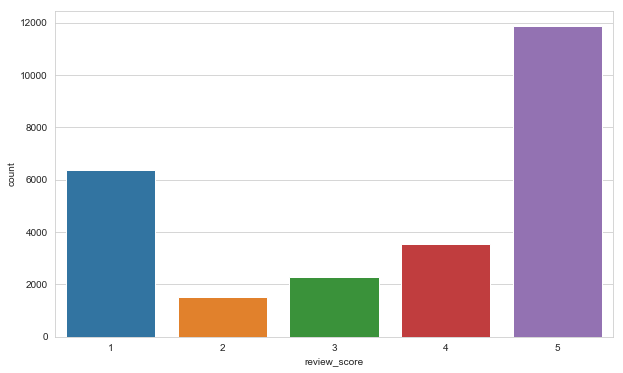

In [119]:
plt.figure(figsize=(10,6))
sns.countplot(NLP_data.review_score)

In [120]:
NLP_good = NLP_data[NLP_data.review_score>3]
print('Number of reviews with score 4 or 5:',NLP_good.shape[0])
NLP_bad = NLP_data[NLP_data.review_score<=3]
print('Number of reviews with score between 1 and 3:',NLP_bad.shape[0])

Number of reviews with score 4 or 5: 15429
Number of reviews with score between 1 and 3: 10141


### WordClouds

One of the easiest way to get an overview of textual data is wordclouds. They are a visual representation of text where the size of the word is scaled with the frequency of the word in the data.

**Function for WordClouds** - From Lecture

In [121]:
def show_wordcloud(data, title,column):
    text = ' '.join(data[column].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,
        max_font_size=100, max_words=100, background_color="white").generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()





From the wordcloud below we see a lot of words occuring often often, e.g. 'produt', 'compr', 'entreb'. <br>
Furthermore we see a lot of of bigrams like 'antrez prazo' and 'produt vei', which we are going to include later in our analysis.

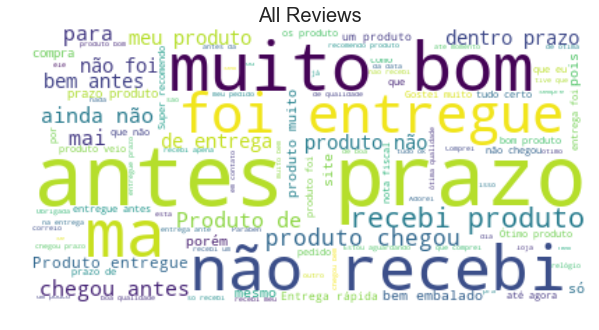

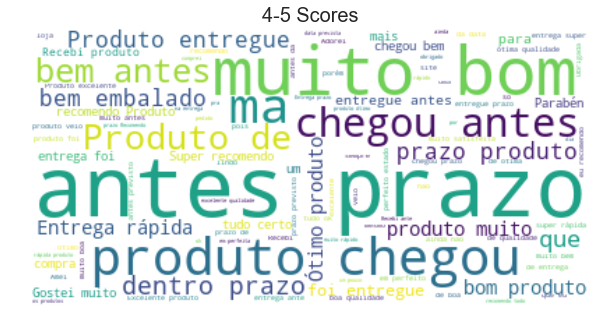

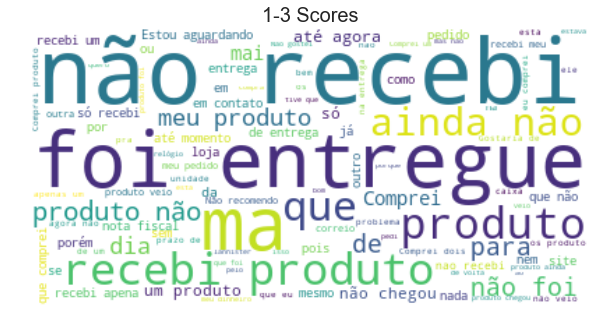

In [122]:
show_wordcloud(NLP_data,'All Reviews','review_comment_message')

show_wordcloud(NLP_good,'4-5 Scores','review_comment_message')

show_wordcloud(NLP_bad,'1-3 Scores','review_comment_message')

#### Review Score over Time
Generally the mean score hovers around 4 over the timespan presented. There is a drop in review scores late 2016 and some outlier values on specific dates. As we using the mean review score the low values on specific dates could be due to a low number of orders (maybe just 1) with low reviews score(s).

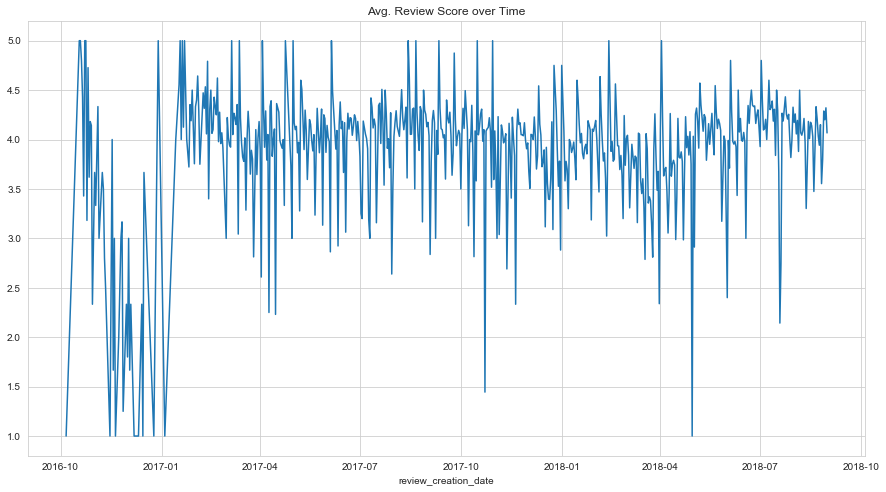

In [123]:
plotdat = df_red.groupby('review_creation_date')['review_score'].mean()
plt.figure(figsize=(15,8))
sns.lineplot(plotdat.index,plotdat.values)
plt.title('Avg. Review Score over Time')
plt.show()

### Average review score by weekday
As the visual above, they all hover around 4 in mean review score. Sunday is the only outlier which is just below 3.5.

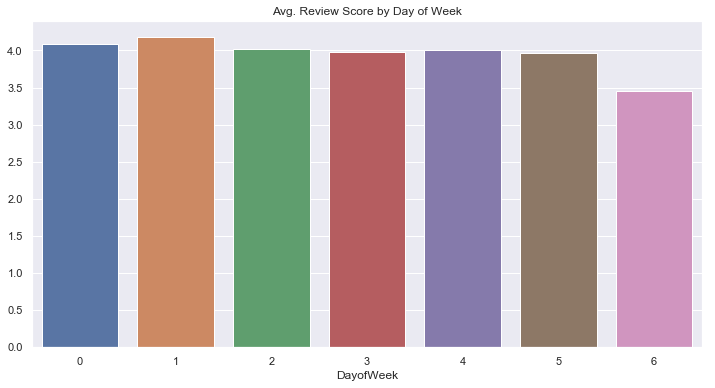

In [189]:
df_red['DayofWeek'] = [i.dayofweek for i in df_red['review_creation_date']]
plotdat = df_red.groupby('DayofWeek')['review_score'].mean()
plt.figure(figsize=(12,6))
sns.barplot(plotdat.index,plotdat.values)
plt.title('Avg. Review Score by Day of Week')
plt.show()

## Data Cleaning

### Duplicates

Our first step in cleaning the data is to remove duplicates. Here we are assuming that the possibility of two individual reviews would never be phrased the exact same way, therefor categorising them as wrong data.


In [125]:
print('Number of duplicate values:', NLP_data[NLP_data.duplicated(subset='review_comment_message', keep='first') == True].shape[0])
print('Quick example of duplicate reviews is obsevation 1 and 2:')
for i in range(5):
    print(i,': ', NLP_data.review_comment_message.iloc[i])

Number of duplicate values: 5192
Quick example of duplicate reviews is obsevation 1 and 2:
0 :  Fui retirar o produto no correio, pois não entregam onde eu moro. E chegou em outra cor , chegou em perfeito estado .

1 :  Comprei e paguei por um produto que nao veio,a oferta era de um combo com 2 pacotes,comprei e paguei por 2 combos,ou seja 4 pacotes,e me enviaram apenas 2 pacotes.quando vou receber o restante????????
2 :  Muito mal embalado 
3 :  Produto de muito boa qualidade, chegou antes do prazo prometido
4 :  Bom de mais comprar com voce


In [126]:
NLP_data = NLP_data[NLP_data.duplicated(subset='review_comment_message', keep='first') == False]
print('Number of observations after removal of duplicates:', NLP_data.shape[0])

Number of observations after removal of duplicates: 20378


#### Define functions for cleaning data

The following function applies the normal proceduceres when cleaning textual data, which includes removing punctuation, removing stopwords and stemming the data. Finally we are removing numbers as they are confusing the translation later in the notebook. <br>
<br>
*Stemming vs. Lemmatizing* <br>
Based on [this site](https://lars76.github.io/nlp/lemmatize-portuguese/) no good lemmatizing-package is available in portugese, thus we decided not to incoorperate lemmatizing. The function is included if able to find a proper package for that. <br>
There are some limitations coming up when choosing to stem vs. lemmatize, as stemming does not always return a real word (e.g. 'compra' -> 'compr'), this makes it harder to interprete for non portugese speakers due to the translation API not working with stemmed words. But as we do not want the algorithm to differ between 'compra' and 'comprei' we are doing stemming and then reversestemming the results, translating and interpreting the topics through that.<br>

In [127]:
st = RSLPStemmer()
def stemText(i):
    i = ' '.join([st.stem(word) for word in i.split()])
    return(i)
def cleanText(i):
    i = ''.join(ch for ch in i if ch not in set(string.punctuation))
    i = ' '.join([word for word in i.split() if word not in portugese_stopwords])
    #i = " ".join([lemmatizer.lemmatize(w) for w in i.split()])
    i = ''.join([ch for ch in i if not ch.isdigit()])
    return i

In [128]:
#Applying the function and defining a new column for cleaned data (cleanReview).
NLP_data = NLP_data.sample(frac=0.5)
NLP_data['cleanReview'] = NLP_data['review_comment_message'].apply(cleanText)
NLP_data.head()

review_comment_message  review_score  \
73681             Foi entregue antes do prazo. Muito bom.             5   
80191   Boa tarde !\r\nBom recebi um produto mas não s...             3   
92394                          Foi conforme ,o combinado.             4   
103428  entregue antes do prazo produto como descrito ...             5   
82211   Produto entregue com agilidade,e o vendedor at...             5   

                                              cleanReview  
73681                  Foi entregue antes prazo Muito bom  
80191   Boa tarde Bom recebi produto sei serve Era ser...  
92394                              Foi conforme combinado  
103428      entregue antes prazo produto descrito anuncio  
82211   Produto entregue agilidadee vendedor atualiza ...

### Creating dictionary for reverse stemming
As we seek to interpret the results, we need to do backwards stemming to the topics, so we can determine the content of each topic later by translating it to english.

In [129]:
#Get all unique words in data
unique_words = set(NLP_data['cleanReview'].str.cat(sep=' ').lower().split())

In [130]:
#Remove all words which only contains special characters
def check(s):
    return all(i in string.punctuation for i in s)
unique_words = [i for i in unique_words if check(i) == False]

In [131]:
stem2word = {}
for word in unique_words:
    word = ''.join(ch for ch in word if ch not in set(string.punctuation))
    word_stem = st.stem(word)
    stem2word.update( {word_stem: word})


In [132]:
stem2word = pd.DataFrame.from_dict(stem2word,orient='index')
stem2word

0
mai           maiores
presciz      prescizo
reforç      reforçado
friday         friday
hidrolis  hidrolisado
...               ...
esquin        esquina
genér        genérico
deramm        deramme
resolçv     resolçver
swith           swith

[5190 rows x 1 columns]

In [133]:
#Stemming the data for further use
NLP_data['cleanReview'] = NLP_data['cleanReview'].apply(stemText)

#Splitting again on cleaned data
NLP_good = NLP_data[NLP_data.review_score>3]
print('Number of reviews with score 4 or 5:',NLP_good.shape[0])
NLP_bad = NLP_data[NLP_data.review_score<=3]
print('Number of reviews with score between 1 and 3:',NLP_bad.shape[0])

Number of reviews with score 4 or 5: 6152
Number of reviews with score between 1 and 3: 4037


## Transformation of Data

In this section we are looking into creating Bag of Words (BoW) and Term Frequency–Inverse Document Frequency (TF-IDF) of our data. The motivation for applying TF-IDF as well, is that we saw specific words appear very often in the wordcloud and these will due to their high frequency not explain a lot of variance, so using weighted data will be needed. <br>
Both are a matrix with the dimensions of number of reviews times number of unique words in the data. The Bag of Words simply counts the number of times a word occurs in the specific review. <br>
The TF-IDF is a bit more complex and instead of only counting the number of occurences it weights them with regards to the frequency of the word in the whole dataset. The calculation is for each word in a review the review-frequency of the word is timed the inverse data-frequency of the word. In the following formula $i$ to a word, $x$ refers to a document and $S$ to the set of documents (corpus).
$$\text{TF-IDF}(i,x,S) = TF(i,x) \cdot IDF(i,S)$$
where:
$$\text{TF}(i,x) = count(i \in X)$$
<br>
$$\text{IDF}(i,S) = log(\frac{N}{count(x \in S : i \in S)})$$
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) <br>

### Bag of Words

In [134]:
count_vect = CountVectorizer(ngram_range=(1,3),min_df=3)
bow_counts = count_vect.fit_transform(NLP_data['cleanReview'].values)

In [135]:
print('Number of unique words in data:', len(count_vect.vocabulary_))
print('First observation includes the words in the following positions of the matrix:','\n',bow_counts[0])

Number of unique words in data: 6821
First observation includes the words in the following positions of the matrix: 
   (0, 2893)	1
  (0, 2186)	1
  (0, 283)	1
  (0, 4513)	1
  (0, 3691)	1
  (0, 700)	1
  (0, 2896)	1
  (0, 2197)	1
  (0, 299)	1
  (0, 4596)	1
  (0, 3701)	1
  (0, 2897)	1
  (0, 2201)	1
  (0, 325)	1
  (0, 4597)	1


### TF-IDF

In [136]:
tf_transformer = TfidfTransformer()
bow_tfidf = tf_transformer.fit_transform(bow_counts)

In [137]:
print('First observation includes words with the following inverse frequency:','\n',bow_tfidf[0])

First observation includes words with the following inverse frequency: 
   (0, 4597)	0.3851358753857023
  (0, 4596)	0.35333523267067624
  (0, 4513)	0.12818564033998264
  (0, 3701)	0.23670279343804623
  (0, 3691)	0.19098890680539482
  (0, 2897)	0.3808567206240703
  (0, 2896)	0.29776932113284904
  (0, 2893)	0.25316289544907233
  (0, 2201)	0.2286556201585974
  (0, 2197)	0.21455404736719846
  (0, 2186)	0.11010861306158846
  (0, 700)	0.16602243145896334
  (0, 325)	0.36372725662922073
  (0, 299)	0.16691328943330427
  (0, 283)	0.14804197354895268


In [138]:
#Define function for later use. The above is used as examples.
def tf_idf_trans(data):
    count_vect = CountVectorizer(ngram_range=(1,3),min_df=3)
    bow_counts = count_vect.fit_transform(data.values)
    tf_transformer = TfidfTransformer()
    bow_tfidf = tf_transformer.fit_transform(bow_counts)
    return(bow_tfidf)

## Topic Modelling

For topic modelling we are using the package called [Gensim](https://radimrehurek.com/gensim/) as the results are easier extracted than the equiavalent models from *SciKit-Learn*, thus easier to reverse-stem and translate. <br>
Learning about Gensim and how to implement is was mainly inspired from this [github-site](https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb).

### Evaluation of models
To tune the number of topics we are going to use [coherence](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0) af our evaluation parameter. Coherence looks at the semantic similarity between the words scoring high in a topic. If a sentence is coherent to its topic the important words for the topic is present in the sentence. According to [this article](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf?fbclid=IwAR2skjRr_EPVDdW1ltnbuDA-qbcwyaw91zVAm4SvQJaOcx9MB2y-aWbDxUc) 'c_v' is the preferred method, thus this is used in this project. <br>
As the coherence intuitively will keep increasing as the number of topics goes towards the number of documents, we are going to apply what's known as the elbow-method. By looking at the coherence for each model we are going to choose the number of topics where the subsequent scores are increasing less than than previous to the chosen model.

### (LSA and) LDA

**LSA** - Latent Semantic Analysis <br>
This brief theory is introduced as LSA was one of the original algorithms for topic modelling, but it had problems with the interpretability of the results, which LDA solves. <br>
LSA is based on dimensionality reduction. Instead of having our massive TF-IDF matrix, $D$, three new matrics will be introduced using singular value decomposition so the following equation is valid:
$$A = U \Sigma T^*$$
Where
* $U$ is a document-topic map (“topic distribution”) - dimension: $N_{documents} \times N_{documents}$
* $\Sigma$ is an ordered diagonal matrix of singular values (“topic importance”) - dimension: $N_{documents} \times N_{topics}$
* $T$ is a term-topic map (“term distribution”) - dimension: $N_{topics} \times N_{topics}$

As $\Sigma$ is ordered from highest to lowest value (importance) choosing the *K* top rows (topics) of matrix $T^*$ will force a truncation of $U$ and $\Sigma$, to dimensions of respectively: $N_{documents} \times K$ and $K \times K$. <br>
The pros of LSA is that the reduction in dimensionality makes further computations more efficient and it only keeps the most valuable information in the data. The cons are that the algorithm is computionally heavy and results can be hard to interpret. It is important to be aware of information lost when using this algorithm, as it can reduce the data quite heavily.<br>
<br>

### Behold
For topic modelling we are going to use **LDA** - Latent Dirichlet Allocation <br>
Based on Bayesian theory LDA creates topic based on probabilistic models. It used priors drawn from the Dirichlet function to get the distributions for the document-topic and the word-topic. The mathematical calculations are based on the following formula:

$$\prod_{I=1}^K P(\varphi_i; \beta) \prod_{j=1}^M P(\theta_j;\alpha) \prod_{t=1}^N P(Z_{j,t} | \theta_j)  P(W_{j,t} | \varphi_{z_{j,y}})$$

The *Generative Story* is as follows ([Source](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)):<br>
* Choose $\theta_i \sim Dir(\alpha)$, where $i \in \{1,\dots,N_{documents}\}$
* Choose $\varphi_k \sim Dir(\beta)$, where $k \in \{1,K\}$
* For each document $i \in \{1,\dots,N_{documents}\}$ and each word in document $j \in \{1,\dots,N_i\}$
    * Choose a topic $z_{i,j} \sim Multinomial(\theta_i)$
    * Choose a word $w_{i,j} \sim Multinomial(\varphi_{z_{j,y}})$

The motivation for doing a Bayesian model is that instead of creating topics based on the data, it creates functions with belonging distributions from which the data could have been drawn/gathered. It initializes by randomly assigning a topic to each document. It then calculates the proportion of words in a document assigned to a specific topic, followed by calculating the proportion of assigned documents to the specific topic of all documents with a specific word. Based on these values the document will be assigned a new topic if needed, and this procedure will be repeated untill a steady state where no topics is being assigned new topics is reached. <br>
<br>
The LDA model has three hyperparameters:
* Number of topics
* $\alpha$ - parameter for the dirichlet-function for topics
* $\beta$ - parameter for the dirichlet-function for words

### Converting data to right format
Instead of a single string Gensim needs every input to be an array of words for each review. This is applied below by splitting each review.

In [139]:
#Example
f = lambda x: x["cleanReview"].split()
xx = NLP_data.apply(f, axis=1).head(5)
xx

73681                   [foi, entreg, ant, praz, muit, bom]
80191     [boa, tard, bom, receb, produt, sei, serv, era...
92394                                [foi, conform, combin]
103428         [entreg, ant, praz, produt, descrit, anunci]
82211     [produt, entreg, agilidade, vend, atualiz, sta...
dtype: object

**Multigram** <br>
Instead of only looking at occurences of single words we are including both bi- and trigrams, which means the model is also looking into phrases of two and three words. This is done so we catch the difference in e.g. 'late delivery' and 'early delivery', which without bigram would go together under 'delivery'.

In [140]:
tokens = xx.tolist()
bigram_model = models.Phrases(tokens)
trigram_model = models.Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

**Creating TF-IDF matrix** <br>
We are filtering out any words which occur in less than three reviews, as we see these as being to specific for a general topic.

In [141]:
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=3) #Do not include words which is in less than 3 reviews
corpus = [dictionary.doc2bow(tok) for tok in tokens]
tfidf = models.TfidfModel(corpus, normalize=True)
corpus = tfidf[corpus]

In [142]:
#As a function
def gensim_data_convert(data):
    f = lambda x: x['cleanReview'].split()
    xx = data.apply(f, axis=1)
    tokens = xx.tolist()
    bigram_model = models.Phrases(tokens)
    trigram_model = models.Phrases(bigram_model[tokens], min_count=1)
    tokens = list(trigram_model[bigram_model[tokens]])
    dictionary = corpora.Dictionary(tokens)
    dictionary.filter_extremes(no_below=3) #Do not include words which is in less than 3 reviews
    corpus = [dictionary.doc2bow(tok) for tok in tokens]
    tfidf = models.TfidfModel(corpus, normalize=True)
    corpus = tfidf[corpus]
    
    return(tokens,dictionary,corpus)

In [143]:
allData_tokens, allData_dictionary, allData_corpus = gensim_data_convert(NLP_data)
good_tokens, good_dictionary, good_corpus = gensim_data_convert(NLP_good)
bad_tokens, bad_dictionary, bad_corpus = gensim_data_convert(NLP_bad)
print('Output and format of TF-IDF corpus for review:')
allData_corpus[1]

Output and format of TF-IDF corpus for review:


[(4, 0.4824724617567302),
 (5, 0.36276372302279686),
 (6, 0.1673474314919464),
 (7, 0.3899444443589508),
 (8, 0.047104032684882315),
 (9, 0.22399159542572109),
 (10, 0.26033557162115173),
 (11, 0.3606049709153804),
 (12, 0.26202110506896026),
 (13, 0.36973549095723224)]

### Functions

A function to return the probabilities of a review being in a category as a dataframe.

In [144]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

def document_topic(model,documentNum,corp):
    topics = [model[corp[i]] for i in range(documentNum)]
    xx = pd.concat([topics_document_to_dataframe(topics_document, num_topics=model.num_topics) for topics_document in topics]) \
      .reset_index(drop=True).fillna(0)
    return xx

The functions in the following cell does the following:
* Converts a stemmed word back to its original form
* Ensures that the following functions works with multigrams and translates top words in each topic from Gensim-model.
* Converts format to right output for translation, using regular expression  RegEx is needed as the out put is long strings with various special characters and numbers.
* Third function applies it to a dataframe for easier readability.

In [305]:
import re

#Function for reverse stemming using the dictionary from earlier
def reverseStem(i):
    for stem, word in stem2word.iterrows():
        #print(stem)
        #print(word)
        if i == stem:
            return(word)


def multigram(string):
    x = re.split(r'_', string)
    xx = list()
    for i in range(len(x)):
        #print(x[i])
        yy = reverseStem(x[i])[0]
        yy = translator.translate(yy,dest='en').text
        xx.append(yy)
    #print(xx)
    y = '_'.join(xx)
    return(y)


def translateTopic(topicNum,num_words,model):
    res = []
    for i in range(int(num_words)):
        s = model.show_topics(formatted=True, num_topics=model.num_topics, num_words=topWords)[topicNum][1].split()[2*i]
        numberpattern = "\d+\.\d+"
        pattern = "\"(.*?)\""
        substring = re.search(pattern, s).group(1)
        #Reverse stem for multigrams
        trans = multigram(substring)
        number = re.search(numberpattern, s).group(0)
        x = [trans,number]
        res.append(x)
    return res


def translateDataFrame(model):
    items= {}
    for i in range(num_topics):
        print('Translating topic:',i)
        g = translateTopic(i,topWords,model)
        items.update( {'Topic {}'.format(i) : g})
    items = pd.DataFrame.from_dict(items)
    return items

### LDA - Latent Dirichlet Analysis

As explained earlier the LDA has three parameters we are going to tune. Instead of tuning all three at once, we are intially tuning the number of topics using the default values for $\alpha$ and $\beta$. This is due to the number of topics being dominant compared to the two others, so the final score will not be highly effected by tuning step by step.

#### Good Reviews (4-5)

In [146]:
start = 2 #Min topic
stop = 20 #Max topic

coh_topic = {}
for i in range(start,stop):
    lda_model = models.LdaModel(good_corpus, num_topics=i, id2word=good_dictionary, passes=4, alpha=[0.01]*i, eta=[0.01]*len(good_dictionary.keys()))
    coherence_model_lda = CoherenceModel(model=lda_model, texts=good_tokens, dictionary=good_dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score for {} topics: '.format(i), coherence_lda)
    
    coh_topic.update( {i: coherence_lda})
    
coh_topic_good = pd.DataFrame.from_dict(coh_topic,orient='index')
coh_topic_good.index.names = ['NumTopic']
coh_topic_good.rename(columns = {coh_topic_good.columns[0]:'Coherence'}, inplace = True)


Coherence Score for 2 topics:  0.19771079886675558

Coherence Score for 3 topics:  0.23054517339076286

Coherence Score for 4 topics:  0.2854291447913236

Coherence Score for 5 topics:  0.32550263761792353

Coherence Score for 6 topics:  0.35445233295574624

Coherence Score for 7 topics:  0.3187255177466133

Coherence Score for 8 topics:  0.3483770622297613

Coherence Score for 9 topics:  0.34688885609760756

Coherence Score for 10 topics:  0.36597136951902737

Coherence Score for 11 topics:  0.3684407308972186

Coherence Score for 12 topics:  0.3820164683986471

Coherence Score for 13 topics:  0.3891806066283341

Coherence Score for 14 topics:  0.37791884582749696

Coherence Score for 15 topics:  0.395090032568796

Coherence Score for 16 topics:  0.3942867337932661

Coherence Score for 17 topics:  0.41473310463364904

Coherence Score for 18 topics:  0.40116882222067207

Coherence Score for 19 topics:  0.393238385528293


In [156]:
choiceNum = 6

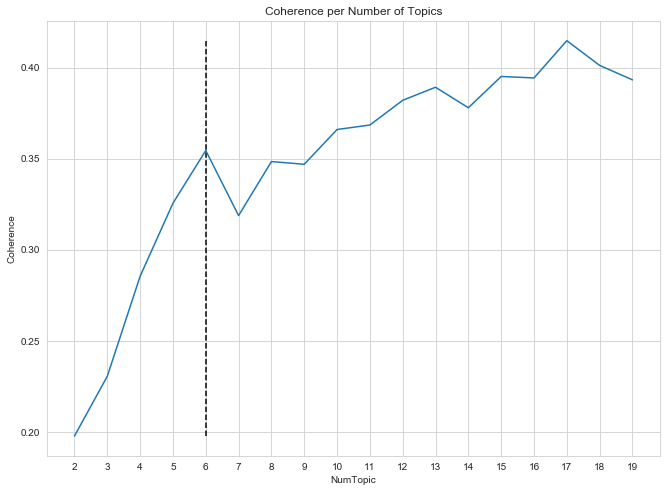

In [157]:
plt.figure(figsize=(11,8))
sns.lineplot(coh_topic_good.index,coh_topic_good.Coherence)
plt.title('Coherence per Number of Topics')
plt.vlines(choiceNum,coh_topic_good.Coherence.min(),coh_topic_good.Coherence.max(),linestyles='dashed')
plt.xticks(range(2,20, 1))
plt.show()

From above we estimate the number of topics for the good reviews to be 8 as the increase in coherence is rather lower afterwards. Below we are applying final parametertuning to model by gridsearching over different values of $\alpha$ and $\beta$. This method can be critisised as in an optimal world a gridsearch for each topic would be applied and the maximal coherence extracted, but due to computer limitations it is in our case applied sequentially.

In [158]:
%%time
#Final parameter tuning

num_topics = choiceNum #Number of topics
alpha = list(np.arange(0.01, 1, 0.2))
beta = list(np.arange(0.01, 1, 0.2))

parameterTuning_good = pd.DataFrame(columns=['Alpha','Beta','Coherence Score'])

for i in range(len(alpha)):
    for j in range(len(beta)):
        lda_model = models.LdaModel(good_corpus, num_topics=num_topics, id2word=good_dictionary, passes=4, alpha = alpha[i], eta=beta[j])
        coherence_model_lda = CoherenceModel(model=lda_model, texts=good_tokens, dictionary=good_dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('\nCoherence Score for Alpha {} and Beta: {}: '.format(alpha[i],beta[j]), coherence_lda)

        parameterTuning_good = parameterTuning_good.append({'Alpha': alpha[i],'Beta' : beta[j], 'Coherence Score' : coherence_lda},ignore_index=True)


Coherence Score for Alpha 0.01 and Beta: 0.01:  0.32083753184416025

Coherence Score for Alpha 0.01 and Beta: 0.21000000000000002:  0.3334261894369425

Coherence Score for Alpha 0.01 and Beta: 0.41000000000000003:  0.3397456691605509

Coherence Score for Alpha 0.01 and Beta: 0.6100000000000001:  0.33519236511502554

Coherence Score for Alpha 0.01 and Beta: 0.81:  0.3407405074938408

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.01:  0.3093122013640937

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.21000000000000002:  0.333069863268642

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.41000000000000003:  0.37745038429144967

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.6100000000000001:  0.35994496710112583

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.81:  0.38871249187565504

Coherence Score for Alpha 0.41000000000000003 and Beta: 0.01:  0.3657100182959289

Coherence Score for Alpha 0.41000000000000003 and Beta: 0.21000000000

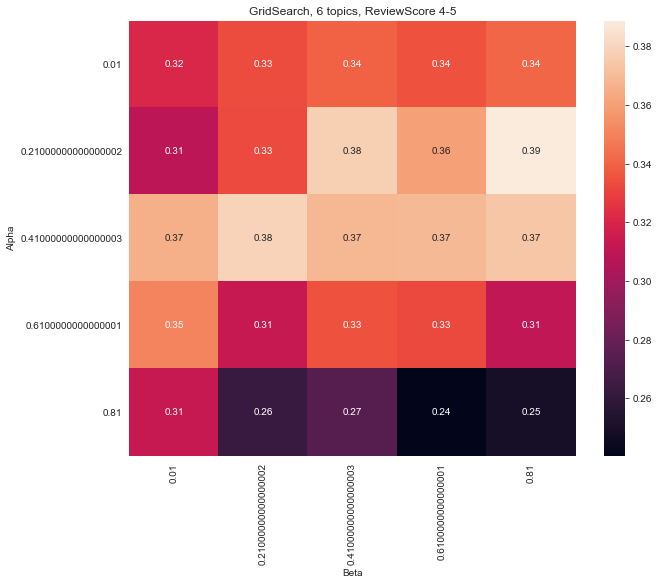

In [166]:
plt.figure(figsize=(10,8))
sns.heatmap(parameterTuning_good.pivot('Alpha','Beta',values = 'Coherence Score'),annot=True)
plt.title('GridSearch, {} topics, ReviewScore 4-5'.format(choiceNum))
plt.show()

Train last model with optimal parameters

In [160]:
#Create final model for further use
num_topics = choiceNum #Number of topics
alpha = parameterTuning_good.iloc[parameterTuning_good['Coherence Score'].idxmax()]['Alpha']
beta = parameterTuning_good.iloc[parameterTuning_good['Coherence Score'].idxmax()]['Beta']
print('Final model with alpha {}, beta {} and {} topics'.format(alpha,beta,num_topics))
lda_model_good = models.LdaModel(good_corpus, num_topics=num_topics, id2word=good_dictionary, passes=4, alpha = alpha, eta=beta)

Final model with alpha 0.21000000000000002, beta 0.81 and 6 topics


#### Bad/Neutral Reviews (1-3)

In [149]:
start = 2 #Min topic
stop = 20 #Max topic

coh_topic = {}
for i in range(start,stop):
    lda_model = models.LdaModel(bad_corpus, num_topics=i, id2word=bad_dictionary, passes=4, alpha=[0.01]*i, eta=[0.01]*len(bad_dictionary.keys()))
    coherence_model_lda = CoherenceModel(model=lda_model, texts=bad_tokens, dictionary=bad_dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score for {} topics: '.format(i), coherence_lda)
    
    coh_topic.update( {i: coherence_lda})
    
coh_topic_bad = pd.DataFrame.from_dict(coh_topic,orient='index')
coh_topic_bad.index.names = ['NumTopic']
coh_topic_bad.rename(columns = {coh_topic_bad.columns[0]:'Coherence'}, inplace = True)


Coherence Score for 2 topics:  0.3471947785422801

Coherence Score for 3 topics:  0.4118281341091294

Coherence Score for 4 topics:  0.4151786718969754

Coherence Score for 5 topics:  0.4481791835079216

Coherence Score for 6 topics:  0.42860367691514184

Coherence Score for 7 topics:  0.4573491226035908

Coherence Score for 8 topics:  0.45209827976799644

Coherence Score for 9 topics:  0.4791301338317079

Coherence Score for 10 topics:  0.44331604667122804

Coherence Score for 11 topics:  0.4343872857425622

Coherence Score for 12 topics:  0.4511301997070571

Coherence Score for 13 topics:  0.4098790302115462

Coherence Score for 14 topics:  0.4445865695081586

Coherence Score for 15 topics:  0.41647985206372123

Coherence Score for 16 topics:  0.4181543252943471

Coherence Score for 17 topics:  0.41182627849230397

Coherence Score for 18 topics:  0.4271173668899151

Coherence Score for 19 topics:  0.42299509236254973


In [180]:
choiceNum = 5

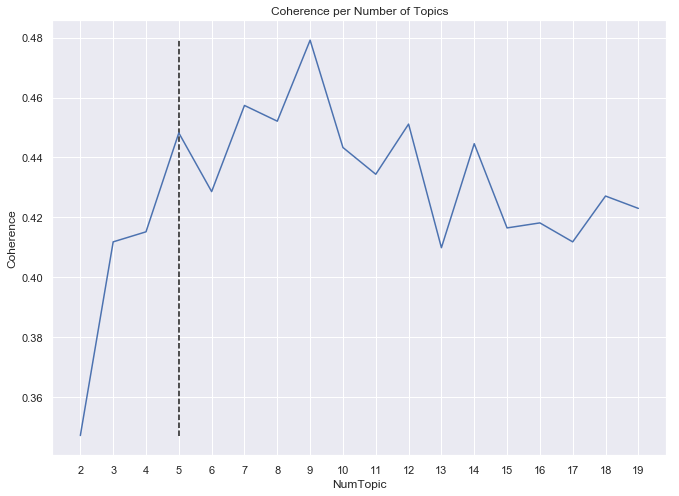

In [181]:
plt.figure(figsize=(11,8))
sns.lineplot(coh_topic_bad.index,coh_topic_bad.Coherence)
plt.title('Coherence per Number of Topics')
plt.vlines(choiceNum,coh_topic_bad.Coherence.min(),coh_topic_bad.Coherence.max(),linestyles='dashed')
plt.xticks(range(2,20, 1))
plt.show()

As for the good reviews we are applying final tuning to the bad/neutral reviews.

In [182]:
%%time
#Final parameter tuning

num_topics = choiceNum #Number of topics
alpha = list(np.arange(0.01, 1, 0.2))
beta = list(np.arange(0.01, 1, 0.2))

parameterTuning_bad = pd.DataFrame(columns=['Alpha','Beta','Coherence Score'])

for i in range(len(alpha)):
    for j in range(len(beta)):
        lda_model = models.LdaModel(bad_corpus, num_topics=num_topics, id2word=bad_dictionary, passes=4, alpha = alpha[i], eta=beta[j])
        coherence_model_lda = CoherenceModel(model=lda_model, texts=bad_tokens, dictionary=bad_dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('\nCoherence Score for Alpha {} and Beta: {}: '.format(alpha[i],beta[j]), coherence_lda)

        parameterTuning_bad = parameterTuning_bad.append({'Alpha': alpha[i],'Beta' : beta[j], 'Coherence Score' : coherence_lda},ignore_index=True)


Coherence Score for Alpha 0.01 and Beta: 0.01:  0.4505258421195629

Coherence Score for Alpha 0.01 and Beta: 0.21000000000000002:  0.4196445278909088

Coherence Score for Alpha 0.01 and Beta: 0.41000000000000003:  0.43611160721854497

Coherence Score for Alpha 0.01 and Beta: 0.6100000000000001:  0.4181328255565213

Coherence Score for Alpha 0.01 and Beta: 0.81:  0.3675199317383394

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.01:  0.45455155429758864

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.21000000000000002:  0.43487476225079985

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.41000000000000003:  0.3960801021716975

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.6100000000000001:  0.36220526163419464

Coherence Score for Alpha 0.21000000000000002 and Beta: 0.81:  0.39763383949313275

Coherence Score for Alpha 0.41000000000000003 and Beta: 0.01:  0.44260951081761124

Coherence Score for Alpha 0.41000000000000003 and Beta: 0.210000000

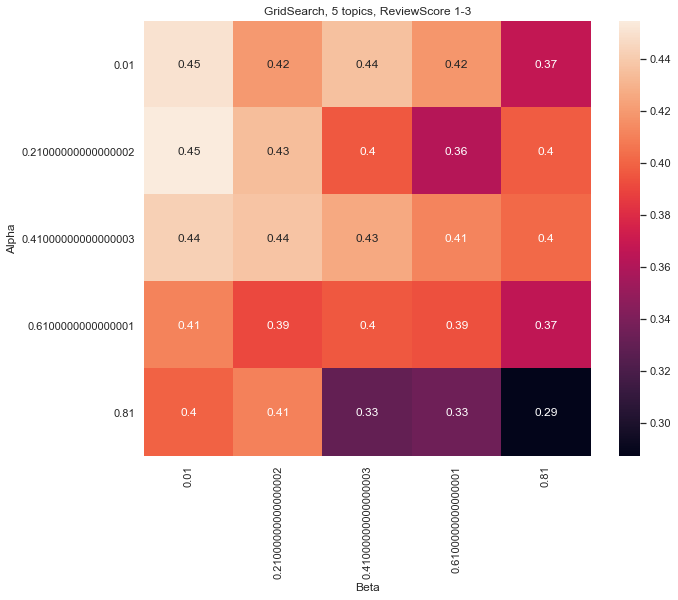

In [183]:
plt.figure(figsize=(10,8))
sns.heatmap(parameterTuning_bad.pivot('Alpha','Beta',values = 'Coherence Score'),annot=True)
plt.title('GridSearch, {} topics, ReviewScore 1-3'.format(choiceNum))
plt.show()

In [184]:
#Create final model for further use
num_topics = choiceNum #Number of topics
alpha = parameterTuning_bad.iloc[parameterTuning_bad['Coherence Score'].idxmax()]['Alpha']
beta = parameterTuning_bad.iloc[parameterTuning_bad['Coherence Score'].idxmax()]['Beta']
print('Final model with alpha {}, beta {} and {} topics'.format(alpha,beta,num_topics))
lda_model_bad = models.LdaModel(bad_corpus, num_topics=num_topics, id2word=bad_dictionary, passes=4, alpha = alpha, eta=beta)

Final model with alpha 0.21000000000000002, beta 0.01 and 5 topics


### Predict topics
We now calculate how much each review is in each topic and take the maximum value and predict that review to being in that topic. The tables below refere to how much the review fits into a topic. Thus if one has 0.49 for topic 2 and 0.51 for topic 5 it is likely a combination of the two topics defining the review.

#### Good Reviews (4-5)

In [167]:
good_topic_dist = document_topic(lda_model_good,len(NLP_good),good_corpus)
good_topic_dist.index = NLP_good.index
NLP_good['LDA_TopicPred'] = good_topic_dist.idxmax(axis=1)
good_topic_dist

0         1         2         3         4         5
73681   0.663109  0.065077  0.064718  0.064754  0.070369  0.071974
92394   0.082146  0.079501  0.079526  0.079630  0.599633  0.079563
103428  0.066815  0.066232  0.065831  0.065905  0.668952  0.066266
82211   0.048393  0.050093  0.750302  0.054028  0.049299  0.047884
102188  0.087958  0.560740  0.087243  0.087605  0.088996  0.087457
...          ...       ...       ...       ...       ...       ...
44647   0.065603  0.065692  0.671852  0.065647  0.065580  0.065626
58372   0.070664  0.373712  0.341302  0.072291  0.071311  0.070721
37024   0.078916  0.602614  0.078931  0.078959  0.078907  0.081673
71514   0.555127  0.088889  0.088767  0.088935  0.089414  0.088868
72360   0.060507  0.057939  0.057065  0.058111  0.058134  0.708244

[6152 rows x 6 columns]

In [300]:
NLP_good.head()

review_comment_message  review_score  \
73681             Foi entregue antes do prazo. Muito bom.             5   
92394                          Foi conforme ,o combinado.             4   
103428  entregue antes do prazo produto como descrito ...             5   
82211   Produto entregue com agilidade,e o vendedor at...             5   
102188             Super recomendo.entrega e produtos ok.             5   

                                              cleanReview  LDA_TopicPred  
73681                        foi entreg ant praz muit bom              0  
92394                                  foi conform combin              4  
103428              entreg ant praz produt descrit anunci              4  
82211   produt entreg agilidade vend atualiz statu com...              2  
102188                      sup recomendoentreg produt ok              1

Quick overview of the frequency of the different topics, which shows topic 4 being the most frequent.

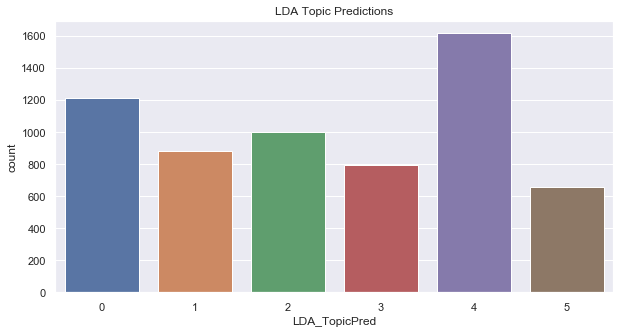

In [169]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(NLP_good['LDA_TopicPred'])
plt.title('LDA Topic Predictions')
plt.show()

From the average score presented below we see that topi 2,3 and 5 are quite lower than the others. Which means these topics are more likely to have a score of 4 than 5.

In [171]:
print('Avg. review score for each Topic:')
print(NLP_good.groupby('LDA_TopicPred')['review_score'].mean())

Avg. review score for each Topic:
LDA_TopicPred
0    4.848885
1    4.822928
2    4.693079
3    4.662469
4    4.819591
5    4.716463
Name: review_score, dtype: float64


#### Bad/Neutral Reviews (1-3)

In [216]:
bad_topic_dist = document_topic(lda_model_bad,len(NLP_bad),bad_corpus)
bad_topic_dist.index = NLP_bad.index
NLP_bad['LDA_TopicPred'] = bad_topic_dist.idxmax(axis=1)
bad_topic_dist

0         1         2         3         4
80191  0.334349  0.058892  0.093726  0.454248  0.058785
89047  0.410913  0.059767  0.409251  0.060308  0.059761
98907  0.062155  0.059326  0.165321  0.653174  0.060023
16628  0.057645  0.585068  0.058243  0.054929  0.244114
92472  0.059491  0.351825  0.059448  0.312975  0.216262
...         ...       ...       ...       ...       ...
5545   0.671790  0.167445  0.055414  0.052732  0.052619
33517  0.053511  0.053963  0.533854  0.305165  0.053507
46769  0.792751  0.051919  0.051852  0.051735  0.051742
40287  0.751357  0.062163  0.061971  0.062541  0.061969
502    0.786194  0.053283  0.053535  0.053589  0.053400

[4037 rows x 5 columns]

In [186]:
NLP_bad.head()

review_comment_message  review_score  \
80191  Boa tarde !\r\nBom recebi um produto mas não s...             3   
89047  Ja passou o prazo de entrega \r\nE o produto a...             1   
98907  Obs: só este produto foi entregue. Lençol Avul...             3   
16628  Esta entrega veio correta mas outra compra da ...             3   
92472  Até agora não recebi o produto, e já foi desco...             1   

                                             cleanReview  LDA_TopicPred  
80191  boa tard bom receb produt sei serv era ser nav...              3  
89047  ja pass praz entreg e produt aind nao cheg o a...              0  
98907  ob produt entreg lençol avuls com elás solt ma...              3  
16628  est entreg vei corret outr compr mesm loj vei ...              1  
92472  até agor receb produt descont prest cart esper...              1

Quick overview of the frequency of the different topics. The distribution of topics is not completely even as topic 2 and 3 is a quite a bit less frequent.

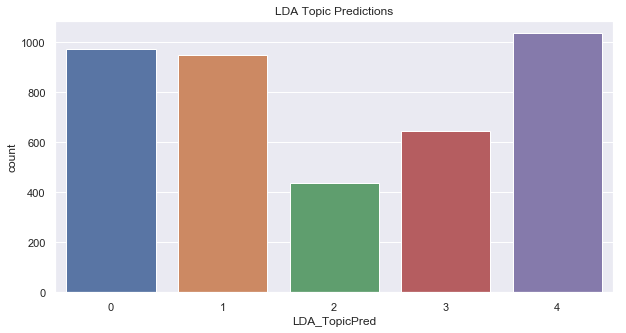

In [187]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(NLP_bad['LDA_TopicPred'])
plt.title('LDA Topic Predictions')
plt.show()

Looking at the average scores they are all quite alike. It can be argued that topic 0 and 2 are a bit higher than the others, thus the probability of having a review score of 3 when in of the two topics are higher.

In [188]:
print('Avg. review score for each Topic:')
print(NLP_bad.groupby('LDA_TopicPred')['review_score'].mean())

Avg. review score for each Topic:
LDA_TopicPred
0    1.632338
1    1.570526
2    1.644495
3    1.593798
4    1.557488
Name: review_score, dtype: float64


### Interpretation of topics
In the following section we are looking into applying some general interpretation to each topic. This is done by reverse stemming and translating the top words og multigrams in each topic. Afterwards we are using a classification model to see which topics contributes most to a high review score.

#### Good Reviews (4-5)

In [295]:
topWords = 25 #Number of words to translate for each topic
translateTopWords_good = translateDataFrame(lda_model_good)
translateTopWords_good

Translating topic: 0


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

##### Insert text about translation

##### Rating topics by feature importance using classification-algorithm
The last step in interpreting the topics is to use the output of the LDA as the independent variables for a classification model. As we have unbalanced data we are going to use a balanced random forest classifier. By looking at the feature importance, the more positive the value of the feature is the more it contribute to a higher score.

In [301]:
labels = NLP_good.review_score.unique()

clf = RandomForestClassifier(random_state=42, class_weight="balanced")
clf.fit(good_topic_dist,NLP_good['review_score'])

names = np.arange(0,good_topic_dist.shape[1])
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.184, 0), (0.174, 4), (0.1652, 3), (0.1596, 1), (0.1591, 5), (0.1581, 2)]


From the above scores it can be interpreted that topic 0 and 4 are most likely to include reviews with highest scores, and thus are most positively minded.

#### Bad/Neutral Reviews (1-3)

In [306]:
topWords = 25 #Number of words to translate for each topic
translateTopWords_bad = translateDataFrame(lda_model_bad)
translateTopWords_bad

Translating topic: 0


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

Above is the 25 highest weighted words or phrases in each topic. We see that almost all categories have words or phrases which are delivery-related. This indicates that a lot of the complaints are regarding the delivery. The elaboration of each topic below will therefor not comment on the delivery aspect. <br>
It should also be noted that there are a few stopwords in the top words like 'are', 'and' and 'to'. It is hard to backtrack how these got in there, as according to the list of stopwords should have been removed, but could be due to the translation. These are ignored in the following elaboration aswell.
* <b> Topic 0: </b>
The most notable words or phrases for this topic is:
    1. *House made*
    2. *on_descriptions*
    3. *cartridges*
    4. *stipulated*
    
    It appears that cartridges is a quite frequent word in this topic, and combining this with stipulated and on-descriptions 
    it could seem that this topic regards items, probabily especially cartridges, not living up to the description or agreement (stipulation) made when the items were ordered. House made could be interpreted as some the items looked homemade or the costumers complaining it could be made better at home. It could be argued that reviews in this topic should be reviewed by sellers selling cartridges and the team behind writing product descriptions.<br>
    <br>
    
* <b> Topic 1: </b>
The most notable words or phrases for this topic is:
    1. *pay_two*
    2. *solicitation_devolution*
    3. *missing*
    4. *prissy*
    5. *bedspreads*
    
    The first one could refer to orders where the customer have paid twice for the same order, thus including the phrase 'pay_two'. 'solicitation_devolution' is a very specific request for the company to decentralize their organizational structure. We see that this topic also covers missing orders as the word 'missing' has high weight. Lastly 'bedspreads' is in top 25 words, which means there appears to be quite a few reviews with bad/neutral scores regarding bedspreads. Reviews in this topic could be reviewed by those handling mistaken orders, as both missing and double-pay is in this topic.<br>
    <br>

* <b> Topic 2: </b>
The most notable words or phrases for this topic is:
    1. *clocks*
    2. *defects*
    3. *give back*
    
    This topic appears to regard defect items which are then requested for a refund. Therefor reviews in this topic should be directed to the team handling returned orders. Furthermore, 'clocks' have a high weight. This could both refere to deliveries being on time and the product 'clock', but further analysis of the reviews in this topic would have to be conducted to determine which this refers to. This is not possible due to limit on translation from Google's API.<br>
    <br>
    
* <b> Topic 3: </b>
The most notable words or phrases for this topic is:
    1. *macaws*
    2. *pillows*
    3. *Address_correct*
    4. *place_wrong*
    
    The last two words seems to be opposite, but as we do not know in which context 'Address_correct' was used, it could be that in the of e.g. 'it was not the correct address'. This is an assumption based on the reviews in these topics has scores from 1-3, and thus are interpreted with a less positive approach. This is therefor not deliverytime related, but appears to be orders delivered to the wrong adress and should therefor be handed by the team handling returned orders. In this topic two very specific categories are present. First 'macaws' is a certain type of parrot and then 'pillows', which make it seem like a lot of reviews in this topic regards these two.<br>
    <br>    
    
* <b> Topic 4: </b>
The most notable words or phrases for this topic is:
    1. *swim*
    2. *Address_wrong*
    3. *charged*
    3. *cartridges*
    
    In topic 4 we again see reviews regarding the adress, and here it is clearly stated that the adress was wrong, thus this should be handled by them team handling returned orders. 'charged' is another word with high weight which could indicate problems with the amount of money charged for a product, thus should be redirected to the people handling money transfers. Again 'cartridges' is a word appearing a lot, as well as in topic 0. This could clearly indicate there was a problem with the cartridges delievered. 'swim' is the 7th highest weighted word in this topic, and can only be interpreted as reviews regarding orders about swim-wear or alike.

##### Rating topics by feature importance using classification-algorithm
As for the reviews with score 4 and 5 we are applying the same model to check for feature importance.

In [302]:
labels = NLP_bad.review_score.unique()

clf = RandomForestClassifier(random_state=42, class_weight="balanced")
clf.fit(bad_topic_dist,NLP_bad['review_score'])

names = np.arange(0,bad_topic_dist.shape[1])
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.2066, 0), (0.2018, 4), (0.1983, 3), (0.1982, 2), (0.1951, 1)]


We see topic 0, 4 and 3 have the highest values, which means reviews in these topics are more likely to have a higher review score. Where on the opposite side topic 1 and 2 would, according to this, be the two topics with the most negative agenda.

## Tuning Number of Topics using Machine Learning
An alternative to finding the optimal number of topics is to use it as a hyperparameter for a classification model. Below a random forest has been implemented predicting the review score with the output of the LDA-model af input. A small gridsearch is made for the random forest, but as we are not interested in the random forests performance but moreso how the ouput of the LDA-model affects the classification, we are not going to add an in depth gridsearch. <br>
We are again testing for 2 to 19 topics, but will not use these values to predict topics and interpret again. We will compare and see if the coherence-tuning achieves the same values as the ML-approach, but mainly the following is used as a comparison and an alternative of tuning the number of topics. <br>
<br>
**Classification Model:**<br>
As we have unbalanced data we are going to use a balanced random forest classifier.  We are doing four cross-validations and therefor evaluating using an average weighted f1-score. The only hyperparameter to fit for the random forest is the number of estimators which we test for $[100,300,500]$.

In [271]:
def ML_topic(X,y,min_topics,max_topics):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    n_topics_list = list(range(min_topics, max_topics, 1))
    
    performance = []
    modelslist = []
    labels = y.unique()
    
    for n_topics in n_topics_list:
        print('Numbers of topics calculating:', n_topics)
        lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)
        X_lda_train = lda.fit_transform(X_train)
        X_lda_test = lda.transform(X_test)

        param_grid = { 
        'n_estimators': [100,300,500]
        }
        clf = RandomForestClassifier(random_state=42, class_weight="balanced")
        CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 4)
        CV_clf.fit(X_lda_train,y_train)

        print(CV_clf.best_params_)

        y_pred = CV_clf.predict(X_lda_test)
        report = classification_report(y_test, y_pred, 
                                       target_names=labels, output_dict=True)
        print(report['weighted avg']['f1-score'])
        performance.append(report['weighted avg']['f1-score'])
        modelslist.append(CV_clf)
        #print(modelslist)
    return performance, modelslist

#### Sunday has lower scores
Instead of looking at the same data, we are looking into what was recognized in the descriptive section. We saw the Sunday had a lower average review score than the other days of the week. This is just used as an example of how the number of topics can be determined as well.

In [266]:
sunday_data = NLP_data.merge(df_red['DayofWeek'], left_index=True, right_index=True)
sunday_data = sunday_data[sunday_data.DayofWeek == 6]
print('Number of observations on Sunday:', sunday_data.shape[0])

Number of observations on Sunday: 787


In [267]:
tfidf_sunday = tf_idf_trans(sunday_data.cleanReview)
perf_sunday, models_sunday = ML_topic(tfidf_sunday,sunday_data.review_score,2,20)

Numbers of topics calculating: 2
{'n_estimators': 100}
0.4103555474199634
Numbers of topics calculating: 3
{'n_estimators': 100}
0.5069118669810216
Numbers of topics calculating: 4
{'n_estimators': 100}
0.431809861595222
Numbers of topics calculating: 5
{'n_estimators': 100}
0.47979895755770663
Numbers of topics calculating: 6
{'n_estimators': 100}
0.4219832500096975
Numbers of topics calculating: 7
{'n_estimators': 100}
0.4370322843731197
Numbers of topics calculating: 8
{'n_estimators': 100}
0.39900857199752643
Numbers of topics calculating: 9
{'n_estimators': 100}
0.4219592375969122
Numbers of topics calculating: 10
{'n_estimators': 100}
0.4257622944331805
Numbers of topics calculating: 11
{'n_estimators': 100}
0.40664775701038647
Numbers of topics calculating: 12
{'n_estimators': 100}
0.4916547151379103
Numbers of topics calculating: 13
{'n_estimators': 100}
0.42050409638714814
Numbers of topics calculating: 14
{'n_estimators': 100}
0.4264501555640796
Numbers of topics calculating:

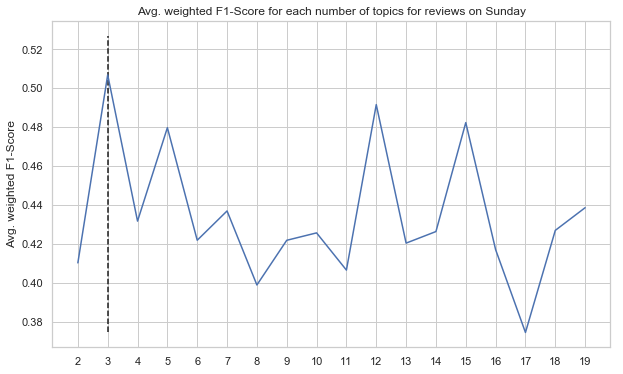

In [268]:
plt.figure(figsize=(10,6))
plt.plot(list(range(2,20, 1)), perf_sunday)
plt.title('Avg. weighted F1-Score for each number of topics for reviews on Sunday')
plt.ylabel('Avg. weighted F1-Score')
plt.xticks(range(2,20, 1))
plt.vlines(np.argmax(perf_sunday)+2,min(perf_sunday),max(perf_sunday)+0.02,linestyles='dashed')
plt.show();

From this we can see that the maximum score is achieved by using three topics. This make sense as the dataset is much smaller than what we previously have used and therefor needs less topics to cover the content of the reviews.

In [290]:
names = np.arange(0,np.argmax(perf_sunday)+2)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), models_sunday[np.argmax(perf_sunday)+2].best_estimator_.feature_importances_),
                 names), 
             reverse=True))

Features sorted by their score:
[(0.2122, 2), (0.2067, 0), (0.2027, 1)]


#### Bonus: Testing if same number of topics is reached using machine learning compared to coherence measure for our two initial datasets

In [283]:
#Create TF-IDF for subsetted datasets
tfidf_bow_good = tf_idf_trans(NLP_good.cleanReview)
tfidf_bow_bad = tf_idf_trans(NLP_bad.cleanReview)

In [284]:
%%time
#Review Score 4-5
perf_good, models_good = ML_topic(tfidf_bow_good,NLP_good.review_score,2,20)

#Review Score 1-3
perf_bad, models_bad = ML_topic(tfidf_bow_bad,NLP_bad.review_score,2,20)

Numbers of topics calculating: 2
{'n_estimators': 300}
0.6640200533212651
Numbers of topics calculating: 3
{'n_estimators': 500}
0.7041292592040584
Numbers of topics calculating: 4
{'n_estimators': 500}
0.7033991527530351
Numbers of topics calculating: 5
{'n_estimators': 300}
0.7106727541737314
Numbers of topics calculating: 6
{'n_estimators': 500}
0.7010564575268224
Numbers of topics calculating: 7
{'n_estimators': 500}
0.7074352433223313
Numbers of topics calculating: 8
{'n_estimators': 500}
0.6989612293676603
Numbers of topics calculating: 9
{'n_estimators': 500}
0.686858886260193
Numbers of topics calculating: 10
{'n_estimators': 500}
0.7112356452514497
Numbers of topics calculating: 11
{'n_estimators': 100}
0.6973215246620149
Numbers of topics calculating: 12
{'n_estimators': 500}
0.6936042376909988
Numbers of topics calculating: 13
{'n_estimators': 300}
0.6861057058314721
Numbers of topics calculating: 14
{'n_estimators': 500}
0.6994173979451269
Numbers of topics calculating: 15


##### Review Score 4-5
Optimal number of topics are 10, which is not aligned with the coherence score where the optimal number was chosen to be 6. The second highest and close in score is 5 topics which is quite close to the number of topics estimated earlier. From the feature importance we see that topic 2, 1 and 3 are most likely to have the reviews with the highest score.

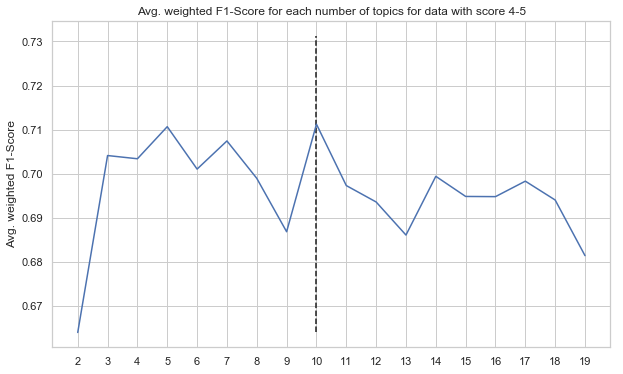

In [285]:
plt.figure(figsize=(10,6))
plt.plot(list(range(2,20, 1)), perf_good)
plt.title('Avg. weighted F1-Score for each number of topics for data with score 4-5')
plt.ylabel('Avg. weighted F1-Score')
plt.xticks(range(2,20, 1))
plt.vlines(np.argmax(perf_good)+2,min(perf_good),max(perf_good)+0.02,linestyles='dashed')
plt.show();

In [291]:
names = np.arange(0,np.argmax(perf_good)+2)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), models_good[np.argmax(perf_good)+2].best_estimator_.feature_importances_),
                 names), 
             reverse=True))

Features sorted by their score:
[(0.1146, 2), (0.0986, 3), (0.0937, 1), (0.0845, 6), (0.0843, 9), (0.0821, 4), (0.0799, 8), (0.0757, 5), (0.0722, 7), (0.0685, 0)]


##### Review Score 1-3
Optimal number of topics are 8, which not to far from the 5 topics chosen by the coherence method. From the feature importance we see that topic 4 and 7 are the most likely topics to have reviews with the highest score.

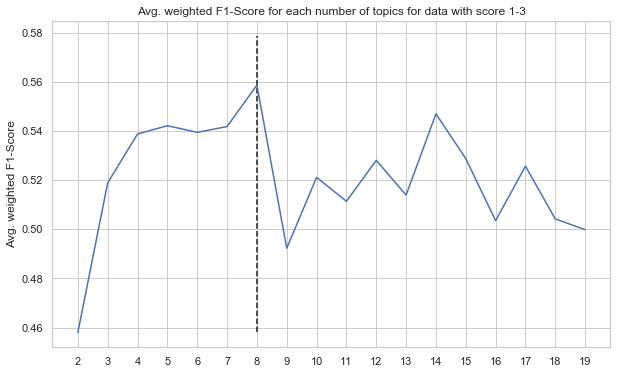

In [286]:
plt.figure(figsize=(10,6))
plt.plot(list(range(2,20, 1)), perf_bad)
plt.title('Avg. weighted F1-Score for each number of topics for data with score 1-3')
plt.ylabel('Avg. weighted F1-Score')
plt.xticks(range(2,20, 1))
plt.vlines(np.argmax(perf_bad)+2,min(perf_bad),max(perf_bad)+0.02,linestyles='dashed')
plt.show();

In [292]:
names = np.arange(0,np.argmax(perf_bad)+2)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), models_bad[np.argmax(perf_bad)+2].best_estimator_.feature_importances_),
                 names), 
             reverse=True))

Features sorted by their score:
[(0.1309, 4), (0.1166, 7), (0.0977, 6), (0.0974, 2), (0.0925, 0), (0.0897, 1), (0.0895, 3), (0.0866, 5)]


### Final remarks on Topic Modelling

It can be concluded that the topics derived in this report are hard to interpret and might be hard to use in production. A lot of the topics regarding delivery was present, which could have been expected. It would have been interesting if there had been some more distinct topics, e.g. one for delivery, one for customer-service etc., as that would have been easier in recommending how to use the results.<br>
It is however, still a relevant model and the KPI is still valuable to the company. The models have been created and if they in the future are fed more data it is likely some better results would be presented.<br>



It is possible to be critisable of the elbow method as it in the end is a visual interpretation of the development of the graph, but neither estimated number of topics using the random forest is not coherent with the coherence scores, thus we can conclude the two methods are not completely aligned in the output. The optimal solution should however be determined by getting topics which are interpretable and makes sense in their categorisations. This is not the case for this report, as all topics reached where a bit undefined and there seemed to be overlaps in the majority of them.


#### Further work
For further work doing topic modelling for each product category could likely provide some interesting results. There might be some useful topics to find within each product category, as we already saw specific products in some of the topics.<br>
Running the models on all of the data is another approach to extend the model, and would be preferred if more computational power was available.